In [2]:
import geopandas

In [3]:
gdf = geopandas.read_file("zip://tabblock2010_53_pophu.zip")

In [4]:
districts = 10
precision = 6
max_tries = 30
district_field = "CD"
population_field = "POP10"

In [5]:
minx, miny, maxx, maxy = gdf.total_bounds
target_population = int(gdf[population_field].sum() / districts)

In [6]:
print(f"Target {target_population} for {districts} districts")
gdf[district_field] = None
for district in range(1, districts):
    ax, ay, bx, by = minx, miny, maxx, maxy

    # dict to store every guess
    considered = {}

    print(f"District {district}: target {target_population}")
    for i in range(max_tries):
        midx = round((bx + ax) / 2, precision)
        if (minx, midx) in considered:
            break

        population = int(gdf[gdf[district_field].isna()].cx[minx:midx,:][population_field].sum())
        print(f"{i}: {minx}, {midx}: {population}")

        considered[(minx, midx)] = abs(population - target_population)

        if population > target_population:
            bx = midx
        elif population < target_population:
            ax = midx
        elif population == target_population:
            break

    # what was the best guess when we stopped
    difference, minx, midx = sorted([(v, k[0], k[1]) for k, v in considered.items()])[0]
    print(f"District {district}: difference {difference}")

    select = gdf[gdf[district_field].isna()].cx[minx:midx, :].index
    gdf.loc[select, district_field] = district
    
    minx = midx


# we don't need to do the last district
# it's just the remainder
population = gdf[gdf[district_field].isna()][population_field].sum()
print(f"District {districts}: {population}")

select = gdf[gdf[district_field].isna()].index
gdf.loc[select, district_field] = districts

Target 672454 for 10 districts
District 1: target 672454
0: -124.848974, -120.882277: 5252522
1: -124.848974, -122.865626: 488396
2: -124.848974, -121.873952: 5180892
3: -124.848974, -122.369789: 2323935
4: -124.848974, -122.617708: 1108570
5: -124.848974, -122.741667: 686420
6: -124.848974, -122.803647: 585924
7: -124.848974, -122.772657: 634571
8: -124.848974, -122.757162: 656585
9: -124.848974, -122.749414: 669099
10: -124.848974, -122.74554: 678441
11: -124.848974, -122.747477: 675477
12: -124.848974, -122.748446: 672949
13: -124.848974, -122.74893: 670918
14: -124.848974, -122.748688: 671537
15: -124.848974, -122.748567: 671948
16: -124.848974, -122.748506: 672791
17: -124.848974, -122.748536: 672649
18: -124.848974, -122.748551: 672649
19: -124.848974, -122.748559: 672457
20: -124.848974, -122.748563: 672234
21: -124.848974, -122.748561: 672234
22: -124.848974, -122.74856: 672234
District 1: difference 3
District 2: target 672454
0: -122.748559, -119.83207: 4995983
1: -122.748559

In [7]:
gdf.groupby("CD").POP10.sum() - target_population

CD
1       3
2    -189
3      -6
4     -62
5      23
6     -13
7      15
8      47
9       0
10    182
Name: POP10, dtype: int64

In [8]:
redistrict = gdf.dissolve(by="CD", aggfunc="sum")

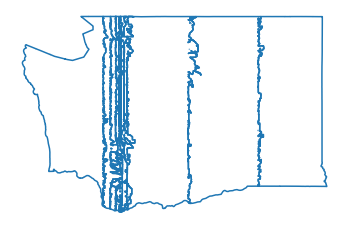

In [9]:
fig = redistrict.boundary.plot()
fig.set_axis_off()

In [10]:
fig.figure.savefig("export.png", dpi=1200)